# Simplest ETU2 model

2 _ \
1 _ _ b \
0 _ _ a\
...A S...

In [1]:
%matplotlib notebook
import matplotlib.pyplot as pl
from scipy import constants
from sympy import init_session, solve, lambdify, Symbol, symbols, Eq
from sympy.physics.mechanics import dynamicsymbols
import sys
sys.path.append('../scripts/')
from virtuaLab import Sample, Laser

## Create new experiment

In [2]:
laser = Laser()
sample = Sample(name='Tm-Yb ETU2')

#### Prepare laser

In [3]:
laser.wavelength = 976e-9 # m
laser.mode = 'linear' # sweep mode: 'linear', 'log', 'pulse'
laser.range = (0.001, 500, 100) # (initial, final, number_of_steps)
laser.samplingPerStep = 400 # number of points per step
laser.samplingRate = 5e4 # number of points per second

#### Rate equations

In [17]:
1/(12e-3)

83.33333333333333

In [18]:
1/1.7e4

5.882352941176471e-05

In [4]:
# Population densities 
Na, Nb, N0, N1, N2 = dynamicsymbols("N_a N_b N_0 N_1 N_2")

# Total population
Nsens, Nact = symbols('N_sens N_act')
sample.props.update({Nsens: 1.52e21})
sample.props.update({Nact: 1.25e19})

# Energy transfer
W0, W1 = symbols('W_0 W_1')
sample.props.update({W0: 1.6e-18}) # energy transfer upconversion rate in s^-1
sample.props.update({W1: 6.2e-16}) # energy transfer upconversion rate in s^-1

# Decay rates
Rba, R10, R20 = symbols('R_{ba} R_{10} R_{20}')
sample.props.update({Rba: 1 / 1.32e-3}) # s^-1
sample.props.update({R10: 1.7e4}) # s^-1
sample.props.update({R20: 1e5}) # s^-1

# Cross section
sigmaab = symbols('sigma_ab')
sample.props.update({sigmaab: 1.69e-20}) # cm^-2

# constants
h, nu = symbols('h nu')
sample.props.update({h: constants.h}) # Planks constant
sample.props.update({nu: constants.c / laser.wavelength}) # frequency of excitation

# time
t = symbols('t')

# power density
p = symbols('rho')

# Rate equations
NaRate = Eq(Na.diff(t), Rba * Nb - sigmaab * p / (h * nu) * (Nsens - Nb))
NbRate = Eq(Nb.diff(t), - NaRate.rhs)

N0Rate = Eq(N0.diff(t), R20 * N2 - W0 * Nb * N0 + R10 * N1)
N1Rate = Eq(N1.diff(t), W0 * Nb * N0 - W1 * Nb * N1 - R10 * N1)
N2Rate = Eq(N2.diff(t), W1 * Nb * N1 - R20 * N2)

# Bind model to sample
sample.model([(Nb, NbRate, 0), (N0, N0Rate, sample.props[Nact]), (N1, N1Rate, 0), (N2, N2Rate, 0)])
sample.boundaryConds = {Nb: [0, sample.props[Nsens]], N0: [0, sample.props[Nact]], N1: [0, sample.props[Nact]], N2: [0, sample.props[Nact]]}
sample.showequations()

Eq(Derivative(N_b(t), t), -R_{ba}*N_b(t) + rho*sigma_ab*(N_sens - N_b(t))/(h*nu))

Eq(Derivative(N_0(t), t), R_{10}*N_1(t) + R_{20}*N_2(t) - W_0*N_0(t)*N_b(t))

Eq(Derivative(N_1(t), t), -R_{10}*N_1(t) + W_0*N_0(t)*N_b(t) - W_1*N_1(t)*N_b(t))

Eq(Derivative(N_2(t), t), -R_{20}*N_2(t) + W_1*N_1(t)*N_b(t))

40000 data points


<IPython.core.display.Javascript object>


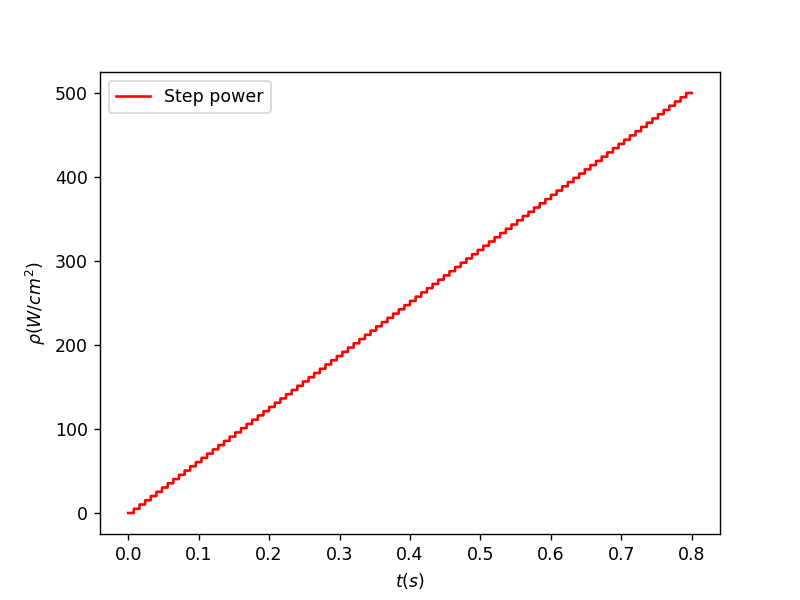

In [5]:
laser.run()
laser.profile()

In [6]:
sample.populatelevels(laser._powerRamp)

Laser on 🚨: 100%|███████████████████████████████| 39999/39999 [29:57<00:00, 22.26it/s]


<IPython.core.display.Javascript object>


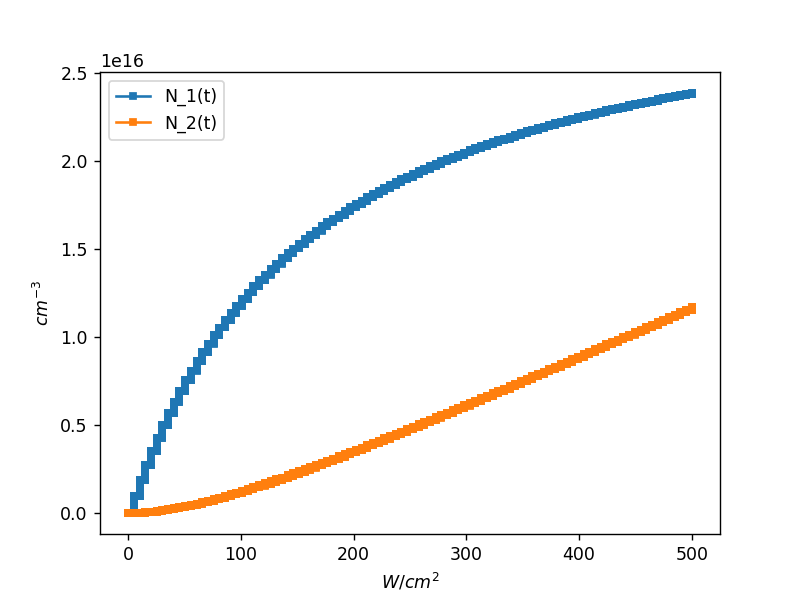

In [8]:
sample.showlevels(x='power', levels=['N_1(t)', 'N_2(t)'])

### Balancing point constants
$\rho_b = \frac{R_{10}R_{ba}}{W_1 N_a}$

$\eta_b = \frac{W_0 N_0 R_{20}^{rad}}{R_{ba}R_{20}}$



In [9]:
rhob = sample.props[R10] * sample.props[Rba] / (sample.props[W1] * sample.props[Nsens])
etab = sample.props[W0] / 1.5e-3 * sample.props[Nact] / (sample.props[Rba] * sample.props[R20])

In [10]:
rhob

13.665946390903946

In [11]:
etab*100

0.0176

In [12]:
sample.save('simplest_etu2.csv')